In [340]:
from pprint import pprint
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import requests
import re
from bs4 import BeautifulSoup as bs, SoupStrainer, Doctype
import xml.etree.ElementTree as ET
from itertools import chain, islice
import fuzzymatcher
%matplotlib inline
style.use('fivethirtyeight')

ModuleNotFoundError: No module named 'fuzzymatcher'

## Load XML data

In [115]:
url_root = 'https://www.usada.org/uploads/web_hist_files/xml/'
years = list(range(2015,2019))

urls = [url_root + str(yr) + 'all.xml' for yr in years]
yr_bytes = [requests.get(u).content for u in urls]

In [116]:
print(urls)

['https://www.usada.org/uploads/web_hist_files/xml/2015all.xml', 'https://www.usada.org/uploads/web_hist_files/xml/2016all.xml', 'https://www.usada.org/uploads/web_hist_files/xml/2017all.xml', 'https://www.usada.org/uploads/web_hist_files/xml/2018all.xml']


In [117]:
for y in yr_bytes:
    print(y[:50])
    print('\n')

b'<TestHistory><TREC><YR>2015</YR><QTR>All</QTR><ANa'


b'\xff\xfe<\x00T\x00e\x00s\x00t\x00H\x00i\x00s\x00t\x00o\x00r\x00y\x00>\x00<\x00T\x00R\x00E\x00C\x00>\x00<\x00Y\x00R\x00>\x002\x00'


b'\xff\xfe<\x00T\x00e\x00s\x00t\x00H\x00i\x00s\x00t\x00o\x00r\x00y\x00>\x00<\x00T\x00R\x00E\x00C\x00>\x00<\x00Y\x00R\x00>\x002\x00'


b'\xff\xfe<\x00T\x00e\x00s\x00t\x00H\x00i\x00s\x00t\x00o\x00r\x00y\x00>\x00<\x00T\x00R\x00E\x00C\x00>\x00<\x00Y\x00R\x00>\x002\x00'




## Parsing XML to DF

In [118]:
roots = {}
athletes = {}
dfs = {}

# Create dict of xml root elements for each year. 
for i, y in enumerate(years):
    roots[y] = ET.fromstring(yr_bytes[i])
    athletes[y] = []
    
    # Filter by sport to create list of athlete dicts for each year.
    for child in roots[y]:
        player_dict = {
            'year': child[0].text,
            'sport': child[4].text,
            'fname': child[5].text,
            'lname': child[6].text,
            'tests': child[3].text
        }
        athletes[y].append(player_dict)
        
    # Create dataframe for each year
    dfs[y] = pd.DataFrame(athletes[y])
    dfs[y] = dfs[y].astype({'tests': 'int64', 'year': 'int64'})

In [119]:
for df in dfs.values():
    print(df.head(), '\n')

      fname    lname              sport  tests  year
0  Madeline    Aaron     Figure Skating      2  2015
1       Max    Aaron     Figure Skating      3  2015
2   Stephen     Abas          Wrestling      1  2015
3     Mason  Abbiate  Paralympic Soccer      1  2015
4    Jeremy   Abbott     Figure Skating      1  2015 

      fname          lname              sport  tests  year
0   Jessica  (Pixler) Tebo    Track and Field      1  2016
1  Madeline          Aaron     Figure Skating      1  2016
2       Max          Aaron     Figure Skating      2  2016
3     Mason        Abbiate  Paralympic Soccer      1  2016
4      Mara         Abbott            Cycling      8  2016 

       fname         lname                 sport  tests  year
0        Max         Aaron        Figure Skating      3  2017
1       Mara        Abbott               Cycling      5  2017
2     Taylor        Abbott              Swimming      2  2017
3  Abdihakim    Abdirahman       Track and Field     10  2017
4     Hakeem  

In [120]:
for d in dfs.values():
    print(d.loc[d.sport == 'Mixed Martial Arts', :].sort_values('tests', ascending=False).head(10), '\n')
    print(d.loc[d.sport == 'Mixed Martial Arts', :].sort_values('tests', ascending=True).head(10), '\n\n')

        fname      lname               sport  tests  year
2564    Ronda     Rousey  Mixed Martial Arts      8  2015
29       Jose       Aldo  Mixed Martial Arts      8  2015
1990    Conor   McGregor  Mixed Martial Arts      8  2015
1282      Dan  Henderson  Mixed Martial Arts      7  2015
1371    Holly       Holm  Mixed Martial Arts      7  2015
647   Antonio   Da Silva  Mixed Martial Arts      7  2015
2536     Yoel     Romero  Mixed Martial Arts      6  2015
2509     Luke   Rockhold  Mixed Martial Arts      6  2015
774    Rafael  Dos Anjos  Mixed Martial Arts      6  2015
184     Vitor    Belfort  Mixed Martial Arts      6  2015 

       fname      lname               sport  tests  year
24     Omari   Akhmedov  Mixed Martial Arts      1  2015
2169     Roy     Nelson  Mixed Martial Arts      1  2015
2121  Gegard    Mousasi  Mixed Martial Arts      1  2015
2083  Takeya   Mizugaki  Mixed Martial Arts      1  2015
1967  Tamdan    McCrory  Mixed Martial Arts      1  2015
1931   Jorge   Mas

In [121]:
# Filter to mma only and combine into 1 df
mma = pd.concat([df.loc[df.sport=='Mixed Martial Arts',:] for df in dfs.values()], axis=0)\
    .drop('sport', axis=1)
sports = pd.concat([df.loc[df.sport!='Mixed Martial Arts',:] for df in dfs.values()], axis=0)

In [122]:
def partial_year_percent(cell):
    '''Calculate % of year under USADA since some are <365 (first year of program
    and current year in progress).'''
    if cell == 2015:
        years = (datetime.date(2016, 1, 1) - start_date).days / 365
    elif cell == end_date.year:
        years = (end_date - datetime.date(end_date.year-1, 12, 31)).days / 365
    else:
        years = 1
    return years

In [123]:
start_date = datetime.date(2015, 7, 1)
end_date = datetime.date.today()
mma['year_percent'] = mma['year'].apply(partial_year_percent)

In [124]:
mma['req_tests'] = np.maximum(mma['tests'] - 2, 0)
mma['scaled_tests'] = mma['tests'] / mma['year_percent']
mma['scaled_req_tests'] = np.maximum(mma['scaled_tests'] - 2, 0)
mma['name'] = mma['fname'] + ' ' + mma['lname']

In [615]:
# Save to csv - give option of loading directly in future sessions rather than scraping. Note that
# this will not be as up to date, however.
mma_file = 'mma.csv'
mma_spread_file = 'mma_spread.csv'
sports_file = 'sports.csv'

mma.to_csv(mma_file, index=False)
sports.to_csv(sports_file, index=False)
print(mma.head())
print(sports.head())

     fname     lname  tests  year  year_percent  req_tests  scaled_tests  \
24   Omari  Akhmedov      1  2015       0.50411          0      1.983696   
29    Jose      Aldo      8  2015       0.50411          6     15.869565   
41   Eddie   Alvarez      2  2015       0.50411          0      3.967391   
44  Thiago     Alves      5  2015       0.50411          3      9.918478   
50   Corey  Anderson      1  2015       0.50411          0      1.983696   

    scaled_req_tests            name  
24          0.000000  Omari Akhmedov  
29         13.869565       Jose Aldo  
41          1.967391   Eddie Alvarez  
44          7.918478    Thiago Alves  
50          0.000000  Corey Anderson  
      fname    lname              sport  tests  year
0  Madeline    Aaron     Figure Skating      2  2015
1       Max    Aaron     Figure Skating      3  2015
2   Stephen     Abas          Wrestling      1  2015
3     Mason  Abbiate  Paralympic Soccer      1  2015
4    Jeremy   Abbott     Figure Skating     

In [126]:
# Spread columns into new df (experimenting).
mma_spread = mma.pivot_table(index=['name', 'fname', 'lname'], columns='year',
     values=['tests', 'scaled_tests', 'req_tests', 'scaled_req_tests']).reset_index()
mma_spread.head()

name        fname           lname req_tests            \
year                                                         2015 2016 2017   
0     Abdul Razak Alhassan        Abdul  Razak Alhassan       NaN  NaN  2.0   
1       Abdul-Kerim Edilov  Abdul-Kerim          Edilov       NaN  0.0  2.0   
2            Abel Trujillo         Abel        Trujillo       2.0  4.0  1.0   
3              Abu Azaitar          Abu         Azaitar       NaN  NaN  NaN   
4              Adam Hunter         Adam          Hunter       NaN  0.0  NaN   

          scaled_req_tests                     scaled_tests            \
year 2018             2015 2016 2017      2018         2015 2016 2017   
0     0.0              NaN  NaN  2.0  2.294118          NaN  NaN  4.0   
1     0.0              NaN  0.0  2.0  0.147059          NaN  2.0  4.0   
2     NaN         5.934783  4.0  1.0       NaN     7.934783  6.0  3.0   
3     0.0              NaN  NaN  NaN  0.147059          NaN  NaN  NaN   
4     NaN              NaN  0.0  NaN       NaN          NaN  2.0  NaN   

               tests                 
year      2018  2015 2016 2017 2018  
0     4.294118   NaN  NaN  4.0  2.0  
1     2.147059   NaN  2.0  4.0  1.0  
2          NaN   4.0  6.0  3.0  NaN  
3     2.147059   NaN  NaN  NaN  1.0  
4          NaN   NaN  2.0  NaN  NaN

In [127]:
# Fighters tested at least once each year since start of program.
all_years = mma_spread.loc[mma_spread.tests.isnull().sum(axis=1) == 0][['name', 'tests']]

print(str(round(100 * all_years.shape[0] / mma_spread.shape[0], 2)) + '%')

12.82%


In [ ]:
# Flattened df (remove multi-index)

col_names = [group + '_' + str(col)[-2:] if col else group for group, col in mma_spread.columns.values]
mma_spread.columns = col_names

In [627]:
# Save to csv for easier loading in future.

mma_spread.to_csv(mma_spread_file, index=False)
mma_spread.head()

,name,fname,lname,req_tests_15,req_tests_16,req_tests_17,req_tests_18,scaled_req_tests_15,scaled_req_tests_16,scaled_req_tests_17,scaled_req_tests_18,scaled_tests_15,scaled_tests_16,scaled_tests_17,scaled_tests_18,tests_15,tests_16,tests_17,tests_18
0,Abdul Razak Alhassan,Abdul,Razak Alhassan,NaN,NaN,2.0,0.0,NaN,NaN,2.0,2.294118,NaN,NaN,4.0,4.294118,NaN,NaN,4.0,2.0
1,Abdul-Kerim Edilov,Abdul-Kerim,Edilov,NaN,0.0,2.0,0.0,NaN,0.0,2.0,0.147059,NaN,2.0,4.0,2.147059,NaN,2.0,4.0,1.0
2,Abel Trujillo,Abel,Trujillo,2.0,4.0,1.0,NaN,5.934783,4.0,1.0,NaN,7.934783,6.0,3.0,NaN,4.0,6.0,3.0,NaN
3,Abu Azaitar,Abu,Azaitar,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.147059,NaN,NaN,NaN,2.147059,NaN,NaN,NaN,1.0
4,Adam Hunter,Adam,Hunter,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN,NaN


In [130]:
fighter_totals = mma['tests'].groupby([mma.name]).sum().sort_values(ascending=False)

print(fighter_totals.head(25))
print(fighter_totals.tail(10))

name
Yoel Romero          38
Holly Holm           35
Rafael Dos Anjos     34
Vitor Belfort        33
Daniel Cormier       33
Cristiane Justino    33
Eddie Alvarez        32
Edson Barboza        29
TJ Dillashaw         29
Dominick Cruz        29
Stipe Miocic         29
Anderson Silva       28
Robbie Lawler        28
Fabricio Werdum      28
Conor McGregor       28
Tecia Torres         27
Johny Hendricks      27
Tyron Woodley        27
Stephen Thompson     27
Frank Edgar          27
Dustin Poirier       26
Jose Aldo            26
Amanda Nunes         26
Aljamain Sterling    25
Donald Cerrone       25
Name: tests, dtype: int64
name
Dominic Waters                          1
Chris Beal                              1
Dileno Lopes                            1
Kalindra Walquiria De Carvalho Faria    1
Chris Dempsey                           1
Michael Wilkinson                       1
Andreas Stahl                           1
Michal Oleksiejczuk                     1
Milana Dudieva              

In [131]:
grouped_avg = mma[['tests', 'scaled_tests', 'req_tests', 'scaled_req_tests']].groupby(mma.year)\
    .agg([np.mean, np.sum, len])
grouped_avg

tests            scaled_tests                     req_tests        \
          mean   sum  len         mean          sum    len      mean   sum   
year                                                                         
2015  2.262821   353  156     4.488747   700.244565  156.0  0.730769   114   
2016  3.907850  2290  586     3.907850  2290.000000  586.0  2.076792  1217   
2017  4.524880  2819  623     4.524880  2819.000000  623.0  2.653291  1653   
2018  2.368142  1338  565     5.084539  2872.764706  565.0  0.592920   335   

          scaled_req_tests                      
      len             mean          sum    len  
year                                            
2015  156         2.496377   389.434783  156.0  
2016  586         2.076792  1217.000000  586.0  
2017  623         2.653291  1653.000000  623.0  
2018  565         3.084539  1742.764706  565.0

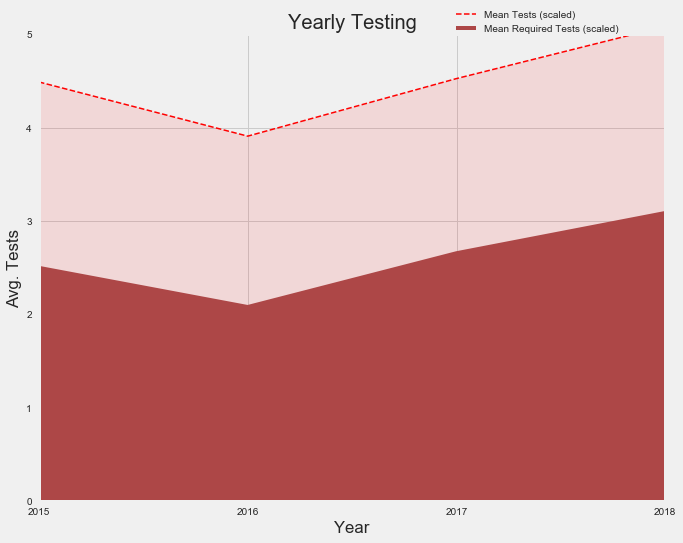

In [132]:
scaled_means = grouped_avg['scaled_tests']['mean'].values
scaled_req_means = grouped_avg['scaled_req_tests']['mean'].values

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(years, scaled_means, color='red', ls='--', lw=1.5, label='Mean Tests (scaled)')
ax.plot(years, scaled_req_means, color='#ad4747', label='Mean Required Tests (scaled)')
ax.fill_between(years, scaled_means, scaled_req_means, alpha=0.1, color='red')
ax.fill_between(years, scaled_req_means, 0, color='#ad4747')
plt.xlim(start_date.year, end_date.year)
plt.xticks(years)
plt.xlabel('Year')
plt.ylim(0, 5)
plt.ylabel('Avg. Tests')
plt.title('Yearly Testing')
plt.legend(loc='upper right', bbox_to_anchor=(.94, 1.07))
plt.show()

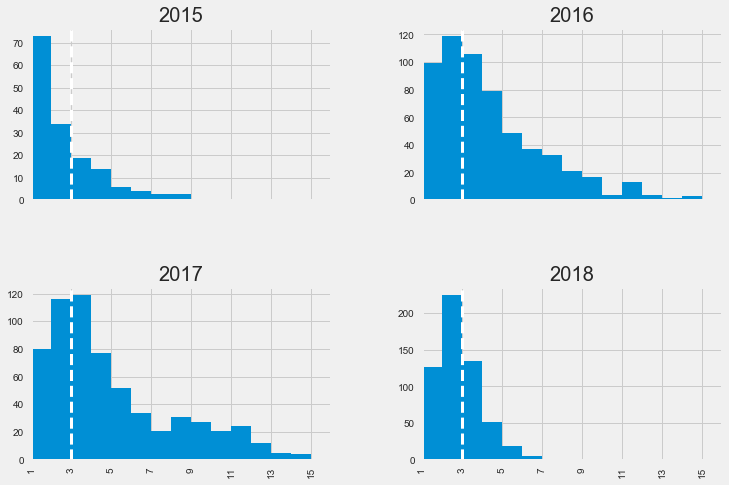

In [133]:
g = mma.hist('tests', by='year', figsize=(12,8), sharex=True, bins=range(16))
for row in g:
    for sub in row:
        sub.axvline(3, ls='--', lw=3, color='white')
plt.xticks(range(1, 17, 2))
plt.xlim(1, 16)
plt.show()

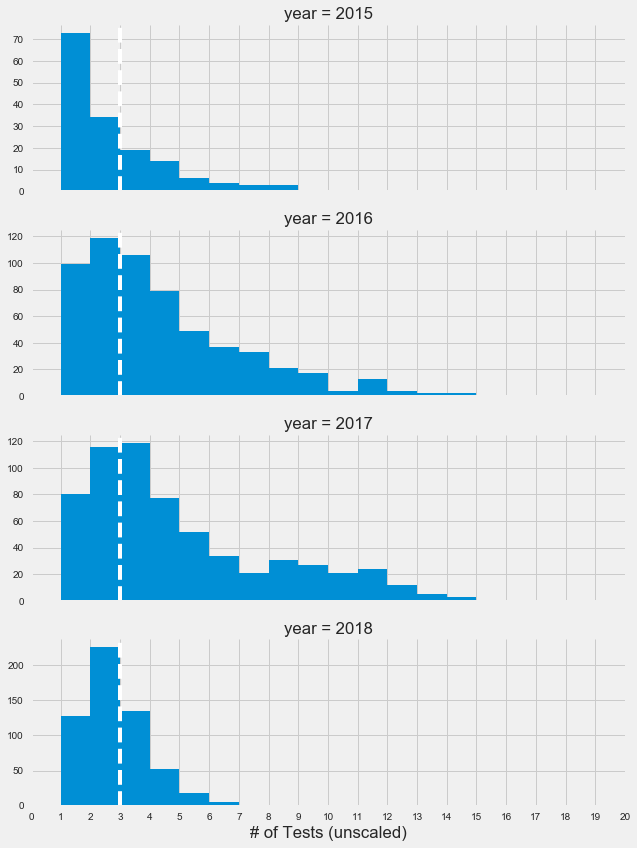

In [134]:
g = sns.FacetGrid(mma, row='year', size=3, aspect=3, sharex=True, sharey=False)
g = g.map(plt.hist, 'tests', bins=range(21))
plt.xlim(0, 20)
plt.xticks(range(21))
plt.xlabel('# of Tests (unscaled)')
for ax in g.axes:
    ax[0].axvline(3, ls='--', color='white')
plt.show()

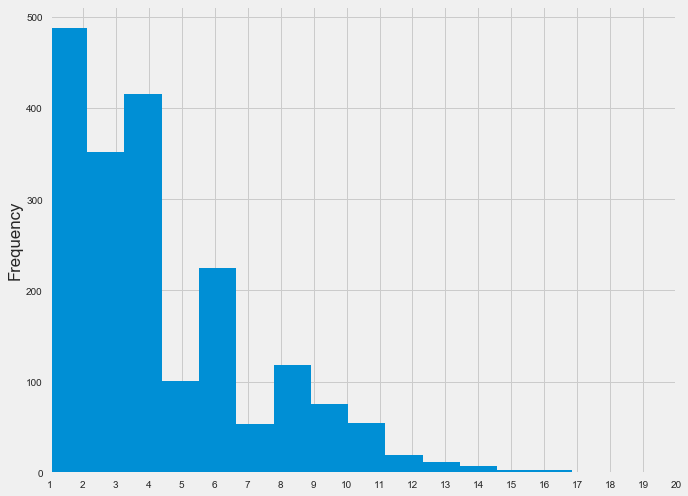

In [135]:
mma['scaled_tests'].plot.hist(figsize=(10,8), bins=20)
plt.xlim(1, 20)
plt.xticks(range(1,21))
plt.show()

In [136]:
# testing - find various percentiles for each year
percentiles = [5, 25, 50, 75, 99]
for p in percentiles:
    print('\n' + str(p))
    print(mma['scaled_tests'].groupby(mma.year).agg(lambda x: np.percentile(x, q=p)))


5
year
2015    1.983696
2016    1.000000
2017    1.000000
2018    2.147059
Name: scaled_tests, dtype: float64

25
year
2015    1.983696
2016    2.000000
2017    2.000000
2018    4.294118
Name: scaled_tests, dtype: float64

50
year
2015    3.967391
2016    3.000000
2017    3.000000
2018    4.294118
Name: scaled_tests, dtype: float64

75
year
2015    5.951087
2016    5.000000
2017    6.000000
2018    6.441176
Name: scaled_tests, dtype: float64

99
year
2015    15.869565
2016    12.000000
2017    13.000000
2018    12.882353
Name: scaled_tests, dtype: float64


In [137]:
rows = mma.shape[0]
for i in range(1,10):
    print('<={} tests: {}'.format(i, round(mma.loc[mma.tests<=i, :].shape[0]/rows, 2)))
    print('<={} required tests: {}\n'.format(i, round(mma.loc[mma.req_tests<=i, :]\
                                                      .shape[0]/rows, 2)))

<=1 tests: 0.2
<=1 required tests: 0.65

<=2 tests: 0.45
<=2 required tests: 0.76

<=3 tests: 0.65
<=3 required tests: 0.83

<=4 tests: 0.76
<=4 required tests: 0.87

<=5 tests: 0.83
<=5 required tests: 0.9

<=6 tests: 0.87
<=6 required tests: 0.93

<=7 tests: 0.9
<=7 required tests: 0.95

<=8 tests: 0.93
<=8 required tests: 0.96

<=9 tests: 0.95
<=9 required tests: 0.98



Idea: Scrape sherdog/wikipedia/fightmatrix/fightmetric/ufci api to find # of fights in UFC each year. This should give a decent approximation of roster size (there will still be some misclassifications with fighters being injured or taking a long time between fights for whatever reason). We want to be able to distinguish between NaN and zero - in other words, was a fighter not in the UFC that year, or were they in the UFC but weren't tested?

In addition, this will give us another factor to analyze in relation to testing #s. We might guess
that USADA is more likely to test those who are scheduled to fight. We can also look at win/loss
records to see if that plays a role (better fighters tested more?). We could also scrape rankings to
check for a similar effect there. 

Other ideas:
-  see if test dates are available somewhere
    -  spread out vs close together?
    -  increase/decrease after a loss?
    -  evenly spaced or unpredictable/variable width?
-  twitter/instagram followers - are more popular fighters targeted?
    -  not sure if historical follower counts available
-  see if test failures are available
-  add nationality (wikipedia?)
-  add fight camp
-  add weight class
-  add previous failures (true/false)
-  add "eye test" (i.e. call out a few obvious examples, leave rest False)
-  add number of title fights

## Comparison w/ other sports

In [139]:
sports_means = sports['tests'].groupby(sports.sport).agg([np.mean, np.sum, len])\
    .sort_values('mean', ascending=False)
    
print(sports_means.head())
print(sports_means.tail())

                          mean   sum  len
sport                                    
Professional Boxing  11.134328   746   67
Speedskating          2.906542   622  214
Tennis                2.750000   231   84
Swimming              2.665775  1994  748
Biathlon              2.584906   137   53
                        mean  sum  len
sport                                 
Field Hockey        1.045045  116  111
Sailing             1.034483   60   58
Water Skiing        1.023810   43   42
Paralympic Fencing  1.000000    2    2
Paralympic Boccia   1.000000    9    9


## Scrape Fightmetric

In [140]:
def scrape_fightmetric(pages=26):
    '''Scrape Fightmetric for all UFC fighter wins and losses.'''
    letters = 'abcdefghijklmnopqrstuvwxyz'
    url = r'http://www.fightmetric.com/statistics/fighters?char='
    urls = [url + letter + '&page=all' for letter in letters]
    content = []
    if pages is not None:
        for i in range(pages):
            temp = requests.get(urls[i])
            if temp.status_code == 200:
                print(f'Scraping {urls[i]}...')
                content.append(temp.content)
            else:
                print(f'Failed to scrape {urls[i]}\nstatus: {temp.status_code}')
    return content

In [141]:
def extract_urls(pages):
    '''Pass in list of requests content from scrape_fightmetric().
    Parse using bs4 and return set of unique urls.
    '''
    strainer = SoupStrainer('a', {'class': 'b-link b-link_style_black'})
    letter_soup = [bs(page, 'lxml', parse_only=strainer) for page in pages]
    
    # Get unique urls from <a> objects. Slice off first tag because it's not a link.
    bs_links = set(link['href'] for page in letter_soup for link in islice(page, 1, None))
    return bs_links

In [232]:
def attr_parser(soup, dtype, attr, element='li'):
    '''Use in scrape_fighter_page func to retrieve field from page.'''
    current_tag = soup.find(lambda tag: tag.name==element and attr in tag.text.lower())
    if current_tag and '--' not in current_tag.text:
        cleaned_text = list(current_tag)[-1].strip().strip('.').strip('\"')
        if '%' in cleaned_text:
            cleaned_text = dtype(cleaned_text.strip('%')) / 100
        if dtype == 'date':
            return datetime.datetime.strptime(cleaned_text, '%b %d, %Y')
        else:
            try:
                return dtype(cleaned_text)
            except ValueError:
                return cleaned_text
    else:
        return None

In [233]:
def year_finder(soup, years):
    '''Use in scrape_fighter_page func to parse fight dates.'''
    dates = []
    for year in years:
        temp = soup.find_all(lambda tag: tag.name=='p' and str(year) in tag.text)
        if temp:
            dates.append(len(temp))
        else:
            dates.append(0)
    if sum(dates) == 0:
        return None
    else:
        return dates

In [639]:
def scrape_fighter_page(url):
    '''Pass in list of fighter urls from extract_urls().
    Scrape each page for W/L record by year, weight class, nationality,
    striking stats, etc.
    '''
    stats = {}
    fields = [(int, 'height'), (int, 'weight'), (int, 'reach'), (str, 'stance'),
              ('date', 'dob'), (float, 'slpm'), (float, 'str. acc'), (float, 'sapm'),
              (float, 'str. def'), (float, 'td avg'), (float, 'td acc'), 
              (float, 'td def'), (float, 'sub. avg')]
    content = requests.get(url).content
    soup = bs(content, 'lxml')
    
    # Check if fighter is active in desired timeframe.
    if year_finder(soup, years):
        stats['year_counts'] = year_finder(soup, years)
    else:
        print('Fighter not active in relevant time range.')
        return None
    
    # Parse name(s).
    stats['name'] = soup.select('.b-content__title-highlight')[0].get_text().strip()
    name_list = stats['name'].split(' ')
    try:
        stats['fname'], stats['lname'] = name_list
    except ValueError:
        stats['fname'] = name_list[0]
        stats['lname'] = ' '.join(name_list[1:])

    # Parse record.
    record = re.findall('\d+', soup.select('.b-content__title-record')[0].get_text())
    try:
        stats['W'], stats['L'], stats['D'] = map(int, record)
    except ValueError:
        stats['W'], stats['L'], stats['D'], stats['NC'] = map(int, record)
        
    # Parse standard fields.
    for dtype, attr in fields:
        stats[attr] = attr_parser(soup, dtype, attr)
    
    # Clean up numeric fields.
    if stats['height']:
        temp = [int(i.strip('\"')) for i in stats['height'].split('\'')]
        stats['height'] = temp[0] * 12 + temp[1]
    stats['weight'] = int(stats['weight'].split(' ')[0])
    print(stats['name'] + ' - scraped')
    return stats

In [142]:
pages_fm = scrape_fightmetric()
urls_fm = extract_urls(pages_fm)

Scraping http://www.fightmetric.com/statistics/fighters?char=a&page=all...
Scraping http://www.fightmetric.com/statistics/fighters?char=b&page=all...
Scraping http://www.fightmetric.com/statistics/fighters?char=c&page=all...
Scraping http://www.fightmetric.com/statistics/fighters?char=d&page=all...
Scraping http://www.fightmetric.com/statistics/fighters?char=e&page=all...
Scraping http://www.fightmetric.com/statistics/fighters?char=f&page=all...
Scraping http://www.fightmetric.com/statistics/fighters?char=g&page=all...
Scraping http://www.fightmetric.com/statistics/fighters?char=h&page=all...
Scraping http://www.fightmetric.com/statistics/fighters?char=i&page=all...
Scraping http://www.fightmetric.com/statistics/fighters?char=j&page=all...
Scraping http://www.fightmetric.com/statistics/fighters?char=k&page=all...
Scraping http://www.fightmetric.com/statistics/fighters?char=l&page=all...
Scraping http://www.fightmetric.com/statistics/fighters?char=m&page=all...
Scraping http://www.fight

In [640]:
fighter_dicts = []
active_fighters = 0
url_list = list(urls_fm)
for i, url in enumerate(url_list):
    print(i, end=' ')
    temp = scrape_fighter_page(url)
    if temp:
        fighter_dicts.append(temp)
        active_fighters += 1
        
        # Make sure scraper is working correctly.
        if active_fighters < 5:
            pprint(fighter_dicts[0])

0 Hu Yaozong - scraped
{'D': 0,
 'L': 1,
 'W': 3,
 'dob': datetime.datetime(1995, 4, 7, 0, 0),
 'fname': 'Hu',
 'height': 75,
 'lname': 'Yaozong',
 'name': 'Hu Yaozong',
 'reach': 72,
 'sapm': 2.65,
 'slpm': 1.06,
 'stance': 'Orthodox',
 'str. acc': 0.44,
 'str. def': 0.42,
 'sub. avg': 2.0,
 'td acc': 0.0,
 'td avg': 0.0,
 'td def': 0.0,
 'weight': 242,
 'year_counts': [0, 0, 1, 0]}
1 Fighter not active in relevant time range.
2 Chris Avila - scraped
{'D': 0,
 'L': 1,
 'W': 3,
 'dob': datetime.datetime(1995, 4, 7, 0, 0),
 'fname': 'Hu',
 'height': 75,
 'lname': 'Yaozong',
 'name': 'Hu Yaozong',
 'reach': 72,
 'sapm': 2.65,
 'slpm': 1.06,
 'stance': 'Orthodox',
 'str. acc': 0.44,
 'str. def': 0.42,
 'sub. avg': 2.0,
 'td acc': 0.0,
 'td avg': 0.0,
 'td def': 0.0,
 'weight': 242,
 'year_counts': [0, 0, 1, 0]}
3 Oluwale Bamgbose - scraped
{'D': 0,
 'L': 1,
 'W': 3,
 'dob': datetime.datetime(1995, 4, 7, 0, 0),
 'fname': 'Hu',
 'height': 75,
 'lname': 'Yaozong',
 'name': 'Hu Yaozong',
 're

In [641]:
df_fm = pd.DataFrame(fighter_dicts)

In [371]:
pd.set_option('display.max_columns', None)
df_fm.head(5)

,D,L,NC,W,dob,fname,height,lname,name,reach,sapm,slpm,stance,str_acc,str_def,sub_avg,td_acc,td_avg,td_def,weight,year_counts,15_rec,16_rec,17_rec,18_rec,reach_height_ratio,reach_weight_ratio,weight_class,age,age_z,reach_z,height_z,sapm_z,slpm_z,str_acc_z,sub_avg_z,td_acc_z,td_avg_z,td_def_z
0,0,1,NaN,3,1995-04-07,Hu,75.0,NaN,Hu Yaozong,72.0,2.65,1.06,Orthodox,0.44,None,2.0,0.00,0.00,0.00,242,"[0, 0, 1, 0]",0,0,1,0,0.960000,0.297521,265,23.221918,-2.134239,-1.811761,0.126299,-0.396414,-1.569574,-0.144072,1.957412,-1.212147,-0.890877,-1.923351
1,0,4,NaN,5,1993-01-16,Chris,70.0,NaN,Chris Avila,72.0,4.17,2.37,Orthodox,0.30,None,0.0,0.00,0.00,0.46,145,"[0, 2, 0, 0]",0,2,0,0,1.028571,0.496552,145,25.443836,-1.499780,0.786654,0.570050,0.539052,-0.601394,-1.128289,-0.477442,-1.497718,-1.126139,-0.506012
2,0,4,NaN,6,1987-08-04,Oluwale,71.0,NaN,Oluwale Bamgbose,78.0,2.70,2.45,Switch,0.48,None,0.0,0.33,0.94,0.37,185,"[1, 2, 2, 0]",1,2,2,0,1.098592,0.421622,185,30.901370,-0.540488,1.212610,-0.959147,-0.210631,-0.504806,0.252706,-0.802308,-0.199778,-0.555317,-0.914975
3,0,14,NaN,26,1978-09-24,Brad,66.0,NaN,Brad Pickett,68.0,4.63,3.02,Orthodox,0.31,None,0.4,0.44,2.47,0.58,135,"[1, 3, 1, 0]",1,3,1,0,1.030303,0.503704,135,39.767123,1.890967,-0.029710,-0.495466,0.781810,-0.088021,-0.754653,-0.226187,0.285511,0.577492,0.060573
4,0,5,NaN,25,1984-07-31,Joseph,64.0,NaN,Joseph Benavidez,65.0,2.50,3.44,Southpaw,0.32,None,0.7,0.27,1.26,0.66,125,"[2, 2, 0, 1]",2,2,0,1,1.015625,0.520000,125,33.912329,0.901224,-0.624378,-0.979376,-0.425634,0.383670,-0.645235,-0.122815,-0.338341,-0.234247,0.530092


In [645]:
df_fm.rename(index=str, inplace=True, columns={'str. acc': 'str_acc',
                         'str. def': 'str_def',
                         'sub. avg': 'sub_avg',
                         'td acc': 'td_acc',
                         'td avg': 'td_avg',
                         'td def': 'td_def'})
print(df_fm.columns)

Index(['D', 'L', 'NC', 'W', 'dob', 'fname', 'height', 'lname', 'name', 'reach',
       'sapm', 'slpm', 'stance', 'str_acc', 'str_def', 'sub_avg', 'td_acc',
       'td_avg', 'td_def', 'weight', 'year_counts'],
      dtype='object')


In [646]:
# Feature creation - split year_counts into separate cols.
for y in years:
    df_fm[str(y)[-2:] + '_rec'] = None
df_fm['15_rec'], df_fm['16_rec'], df_fm['17_rec'], df_fm['18_rec']  = zip(*df_fm.year_counts)

In [649]:
# Create option to group heavyweights together, since they are the only weight
# class where different weights are listed.
df_fm['weight_class'] = df_fm['weight'].apply(lambda x: x if x < 206 else 265)
df_fm['age'] = (datetime.datetime.today() - df_fm.dob).dt.days / 365
df_fm['reach_height_ratio'] = df_fm.reach / df_fm.height
df_fm['reach_weight_ratio'] = df_fm.reach / df_fm.weight

In [650]:
df_fm.sort_values('reach_height_ratio', ascending=True)\
    [['name', 'reach_height_ratio', 'reach_weight_ratio', 'reach', 'height', 'weight']].head(10)

,name,reach_height_ratio,reach_weight_ratio,reach,height,weight
18,Artem Lobov,0.942029,0.448276,65.0,69.0,145
542,Jocelyn Jones-Lybarger,0.955224,0.556522,64.0,67.0,115
30,Cody Garbrandt,0.955882,0.481481,65.0,68.0,135
843,Leslie Smith,0.956522,0.488889,66.0,69.0,135
0,Hu Yaozong,0.960000,0.297521,72.0,75.0,242
607,Milana Dudieva,0.968254,0.451852,61.0,63.0,135
859,Lisa Ellis,0.968750,0.539130,62.0,64.0,115
758,Molly McCann,0.968750,0.496000,62.0,64.0,125
668,Maia Stevenson,0.968750,0.539130,62.0,64.0,115
387,Emily Whitmire,0.969231,0.504000,63.0,65.0,125


In [651]:
# Note that reach_weight_ratio is skewed due to weight cutting 
# (with the exception of most heavyweights). 
df_fm.sort_values('reach_weight_ratio', ascending=False)\
    [['name', 'reach_height_ratio', 'reach_weight_ratio', 'reach', 'height', 'weight']].head(10)

,name,reach_height_ratio,reach_weight_ratio,reach,height,weight
589,Ashley Yoder,1.029851,0.600000,69.0,67.0,115
311,Pearl Gonzalez,1.062500,0.591304,68.0,64.0,115
45,Valerie Letourneau,1.014925,0.591304,68.0,67.0,115
663,Ericka Almeida,1.030303,0.591304,68.0,66.0,115
790,Jessica Rakoczy,1.014925,0.591304,68.0,67.0,115
364,JJ Aldrich,1.030769,0.582609,67.0,65.0,115
483,Cortney Casey,1.000000,0.582609,67.0,67.0,115
707,Tatiana Suarez,1.030769,0.582609,67.0,65.0,115
410,Chanmi Jeon,1.030769,0.582609,67.0,65.0,115
368,Maryna Moroz,1.000000,0.582609,67.0,67.0,115


In [652]:
# Compute average stats by weight class
weight_stats = df_fm[['age', 'reach', 'height', 'sapm', 'slpm', 'str_acc', 'str_def', 'sub_avg',
       'td_acc', 'td_avg', 'td_def']].groupby(df_fm['weight_class']).agg([np.mean, np.std])
weight_stats

age                reach               height            \
                   mean       std       mean       std       mean       std   
weight_class                                                                  
115           30.550187  4.375032  64.634615  2.067762  64.072727  1.874335   
125           30.444101  3.860511  66.439560  2.305591  65.563830  1.596761   
135           31.186596  4.543436  68.075000  2.524377  66.876033  1.768098   
145           31.018595  3.709744  70.339623  2.110684  68.907407  1.916661   
155           31.874107  3.599403  71.521429  2.133892  69.915493  1.586704   
170           32.515926  3.965366  73.382716  2.141387  71.435583  1.784836   
185           33.330892  4.474773  74.865979  2.584525  72.724490  1.797940   
205           33.054230  4.559201  75.761194  2.594222  73.705882  1.584051   
265           34.243753  5.159158  77.046875  2.785619  74.727273  2.159383   

                  sapm                slpm             str_acc            \
                  mean       std      mean       std      mean       std   
weight_class                                                               
115           3.956364  1.572600  3.767273  1.559003  0.434364  0.116536   
125           3.127660  1.432487  2.959787  1.268338  0.387872  0.106598   
135           3.354545  1.639045  3.224545  1.536019  0.402562  0.110201   
145           3.343519  1.576697  3.331111  1.521766  0.422315  0.105064   
155           3.350559  1.415924  3.224685  1.561122  0.414825  0.091358   
170           3.281840  1.292603  3.110429  1.090314  0.425399  0.081333   
185           2.970000  1.281865  3.113163  1.313698  0.452245  0.109831   
205           3.430147  1.417168  3.671176  1.641717  0.466324  0.099550   
265           3.256970  1.531150  3.137727  1.323752  0.457121  0.118838   

               str_def             sub_avg              td_acc            \
                  mean       std      mean       std      mean       std   
weight_class                                                               
115           0.534909  0.119967  0.781818  1.771910  0.376000  0.279063   
125           0.572128  0.127261  0.838298  1.373177  0.356809  0.257925   
135           0.564215  0.110255  0.697521  1.352187  0.374545  0.260275   
145           0.563519  0.106598  0.686111  1.437057  0.363333  0.239036   
155           0.551958  0.105858  0.539860  0.610027  0.355315  0.247218   
170           0.550675  0.082163  0.492638  0.718929  0.357239  0.243430   
185           0.539694  0.112913  0.623469  0.777095  0.380918  0.254874   
205           0.527206  0.110018  0.569118  1.152319  0.320147  0.246246   
265           0.499091  0.123397  0.507576  0.762448  0.360303  0.297244   

                td_avg              td_def            
                  mean       std      mean       std  
weight_class                                          
115           1.372727  1.384993  0.466182  0.285511  
125           1.700745  1.894297  0.513617  0.296252  
135           1.590744  1.530574  0.571322  0.276357  
145           1.634167  1.449897  0.585741  0.247874  
155           1.554126  1.405888  0.550839  0.276152  
170           1.435583  1.290626  0.591902  0.253870  
185           1.690816  1.352050  0.592143  0.242786  
205           1.519559  1.586867  0.572647  0.295542  
265           1.266515  1.421650  0.598485  0.311168

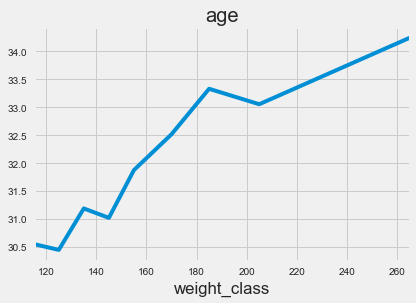

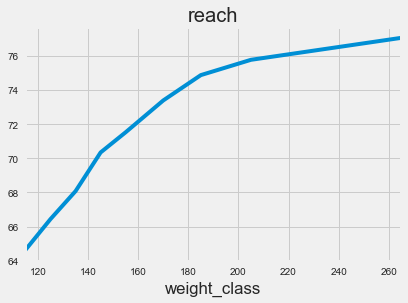

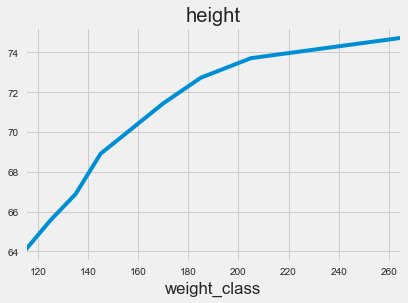

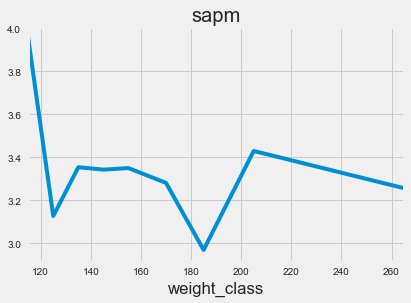

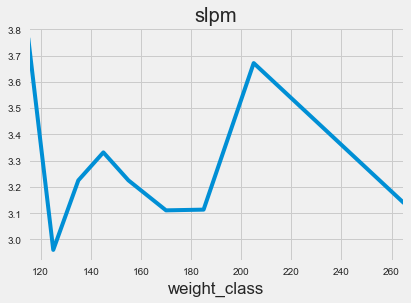

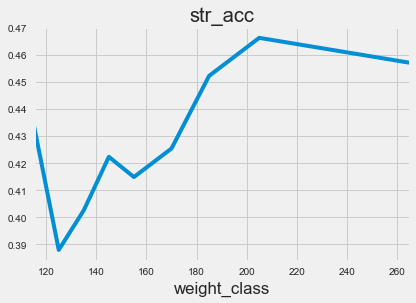

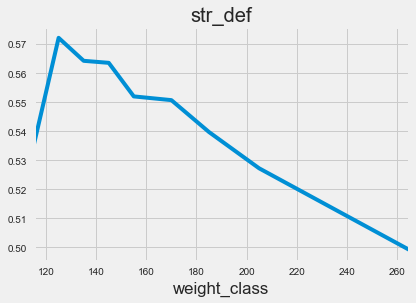

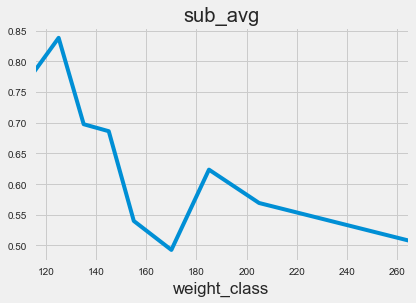

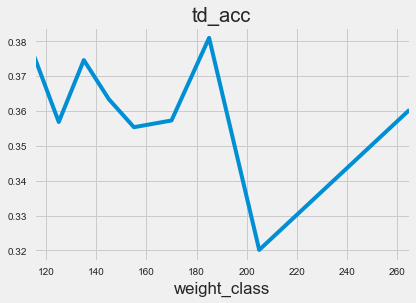

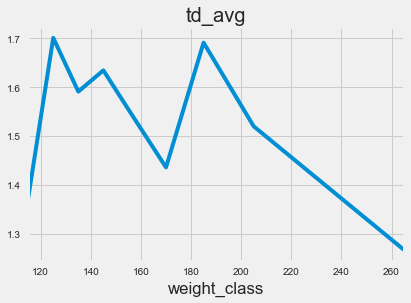

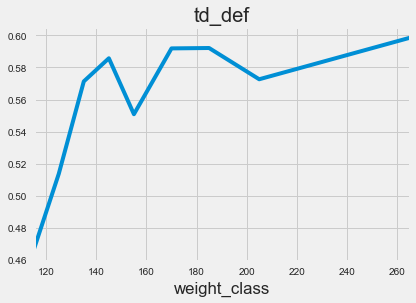

In [654]:
scaleable_cols = weight_stats.columns[::2]
for c in scaleable_cols:
    fig, ax = plt.subplots()
    weight_stats[c].plot.line()
    plt.title(c[0])
plt.show()

Notes
--------
- lhw and hw metagames look significantly different
- age trend even more pronounced than expected
- 185 seems to stand out as a bit lower volume than might be expected
- 115 and 125 hugely different striking stats - could be partly bc 125 and 135 
    (and a little of 145) combine mens and womens stats
- submissions a bigger part of the lower weight class game as expected, interesting to see
    the jump from 170 to 185 though
- strawweights don't shoot many takedowns but they have a high success rate - maybe skewed
    by Suarez?

In [660]:
# Most hittable fighters by %
df_fm.loc[0 < df_fm.str_def, :].sort_values('str_def').head(15)

,D,L,NC,W,dob,fname,height,lname,name,reach,sapm,slpm,stance,str_acc,str_def,sub_avg,td_acc,td_avg,td_def,weight,year_counts,15_rec,16_rec,17_rec,18_rec,weight_class,age,reach_height_ratio,reach_weight_ratio
618,0,1,NaN,8,1988-08-19,Priscila,67.0,Cachoeira,Priscila Cachoeira,65.0,10.09,0.21,Orthodox,0.16,0.15,0.0,0.00,0.00,0.00,125,"[0, 0, 0, 1]",0,0,0,1,125,29.868493,0.970149,0.520000
703,0,7,1.0,21,1985-06-09,John,71.0,Phillips,John Phillips,75.0,2.77,0.00,Southpaw,0.00,0.21,0.0,0.00,0.00,0.00,185,"[0, 0, 0, 1]",0,0,0,1,185,33.065753,1.056338,0.405405
435,0,3,NaN,9,1988-11-28,Mike,76.0,Rodriguez,Mike Rodriguez,82.0,3.13,2.72,Southpaw,0.54,0.21,0.0,0.00,0.00,0.41,205,"[0, 0, 0, 1]",0,0,0,1,205,29.591781,1.078947,0.400000
339,0,3,NaN,8,1989-02-13,James,76.0,Bochnovic,James Bochnovic,81.0,3.64,0.65,Orthodox,0.26,0.21,0.0,0.00,0.00,0.00,205,"[0, 0, 1, 1]",0,0,1,1,205,29.380822,1.065789,0.395122
101,0,4,NaN,15,1986-07-03,Tim,74.0,Williams,Tim Williams,76.0,8.95,4.21,Orthodox,0.44,0.22,0.0,0.00,0.00,0.00,185,"[0, 0, 0, 2]",0,0,0,2,185,32.000000,1.027027,0.410811
290,0,4,NaN,8,1978-02-23,Ruan,74.0,Potts,Ruan Potts,75.0,5.92,0.85,Orthodox,0.37,0.22,2.3,0.16,0.75,0.33,247,"[1, 0, 0, 0]",1,0,0,0,265,40.361644,1.013514,0.303644
549,0,4,1.0,10,1989-11-11,Yana,66.0,Kunitskaya,Yana Kunitskaya,68.0,9.66,1.46,Orthodox,0.45,0.23,0.0,0.25,4.39,0.00,145,"[0, 0, 0, 1]",0,0,0,1,145,28.638356,1.030303,0.468966
497,0,4,NaN,13,1989-10-10,Marcin,70.0,Bandel,Marcin Bandel,70.0,5.26,0.79,Orthodox,0.50,0.23,0.0,0.00,0.00,0.00,155,"[1, 0, 0, 0]",1,0,0,0,155,28.726027,1.000000,0.451613
816,0,3,1.0,8,1985-07-24,Bubba,72.0,Bush,Bubba Bush,73.0,7.01,0.63,Orthodox,0.55,0.25,0.0,0.50,2.82,0.60,185,"[1, 0, 0, 0]",1,0,0,0,185,32.942466,1.013889,0.394595
394,0,3,NaN,9,1986-11-19,Ian,65.0,Entwistle,Ian Entwistle,64.0,7.36,0.11,Orthodox,0.07,0.31,12.1,0.00,0.00,0.00,135,"[0, 1, 0, 0]",0,1,0,0,135,31.619178,0.984615,0.474074


In [661]:
def scale_stats(row, to_scale, weight_class_stats):
    '''Compute z-score by weight class.'''
    weight = row.weight_class
    unscaled = row[to_scale]
    scaled = (unscaled - weight_class_stats[to_scale]['mean'][weight]) \
        / weight_class_stats[to_scale]['std'][weight]
    return scaled

In [662]:
scale_names = [col[0] for col in scaleable_cols]
for c in scale_names:
    df_fm[c + '_z'] = df_fm.apply(scale_stats, axis=1, args=(c, weight_stats))

In [664]:
for col in scale_names:
    print('\n' + col + '_z')
    print(df_fm[['name', 'weight_class', col, col+'_z']].\
        sort_values(col + '_z', ascending=False).head(10))


age_z
                  name  weight_class        age     age_z
638      Dan Henderson           185  47.868493  3.248791
37      Anthony Perosh           205  45.750685  2.784798
533  Yoshihiro Akiyama           170  42.936986  2.628020
342          Mike Pyle           170  42.797260  2.592783
427     Chris Clements           170  42.402740  2.493291
634   Tatsuya Kawajiri           145  40.158904  2.463865
790    Jessica Rakoczy           115  41.224658  2.439861
807            BJ Penn           145  39.558904  2.302129
337       Dennis Siver           145  39.473973  2.279235
597        Reza Madadi           155  40.041096  2.268984

reach_z
               name  weight_class  reach   reach_z
21        Jon Jones           205   84.0  3.175830
306      Neil Magny           170   80.0  3.090186
396  Dominic Waters           170   79.0  2.623199
401       Kevin Lee           155   77.0  2.567408
351    Felipe Silva           155   77.0  2.567408
261   Glaico Franca           155   77.0

In [665]:
# Feature creation.
df_fm['NC'] = df_fm['NC'].fillna(0).astype('int')
df_fm['total_fights'] = df_fm.W + df_fm.L + df_fm.D + df_fm.NC
df_fm['win_perc'] = (df_fm.W + 0.5 * df_fm.D) / (df_fm.total_fights - df_fm.NC)
df_fm['lname'] = df_fm['name'].apply(lambda cell: ' '.join(cell.split(' ')[1:]))

In [672]:
# Lowest career w% for fighters who managed to stay in the UFC and fight regularly
year_cols = [col for col in df_fm.columns if 'rec' in col]
(df_fm.loc[df_fm[year_cols].sum(axis=1) > 5, ['name', 'win_perc', 'W', 'L', 'D', 'NC'] + year_cols]
    .sort_values('win_perc').head(15))

,name,win_perc,W,L,D,NC,15_rec,16_rec,17_rec,18_rec
206,Kailin Curran,0.400000,4,6,0,0,2,2,2,0
378,Bec Rawlings,0.466667,7,8,0,0,1,2,2,1
18,Artem Lobov,0.500000,14,14,1,1,1,3,2,0
670,Mark Hunt,0.519231,13,12,1,1,2,2,2,1
483,Cortney Casey,0.538462,7,6,0,0,2,3,2,1
876,Alex Caceres,0.541667,13,11,0,1,1,3,3,1
24,Raquel Pennington,0.562500,9,7,0,0,2,3,0,1
194,Randa Markos,0.571429,8,6,0,0,2,2,2,2
587,Michael Johnson,0.580645,18,13,0,0,3,2,1,1
693,Damien Brown,0.586207,17,12,0,0,0,3,2,1


In [677]:
df_fm['name'].groupby([df_fm.weight_class, df_fm.stance]).count()

weight_class  stance  
115                        12
              Orthodox     38
              Southpaw      4
              Switch        1
125                        15
              Orthodox     63
              Southpaw     12
              Switch        4
135                        10
              Orthodox     90
              Southpaw     15
              Switch        6
145                         7
              Orthodox     81
              Southpaw     16
              Switch        4
155                        11
              Orthodox     98
              Southpaw     30
              Switch        4
170                         7
              Orthodox    111
              Southpaw     34
              Switch       11
185                         3
              Orthodox     63
              Southpaw     28
              Switch        4
205                         3
              Orthodox     53
              Southpaw     10
              Switch        2
265              

In [679]:
df_fm[['sapm', 'slpm', 'str_acc', 'str_def']].groupby(df_fm.stance).mean()

,sapm,slpm,str_acc,str_def
stance,,,,
,2.951429,2.839429,0.352000,0.471286
Orthodox,3.396421,3.270584,0.427097,0.555591
Southpaw,3.124522,3.227325,0.441911,0.557580
Switch,3.255789,3.439474,0.459737,0.538947


In [680]:
# Feature creation.
df_fm['brawl_score'] = df_fm.slpm + df_fm.sapm
df_fm['strike_diff'] = df_fm.slpm - df_fm.sapm
df_fm['strike_ratio'] = df_fm.slpm / df_fm.sapm

In [681]:
for col in ['brawl_score', 'strike_diff', 'strike_ratio']:
    print(col + '\n')
    print(df_fm.loc[(df_fm.sapm != 0) | (df_fm.slpm != 0), ['name', 'sapm', 'slpm', col]]\
    .sort_values(col))

brawl_score

                      name   sapm   slpm  brawl_score
74             Filip Pejic   0.88   0.00         0.88
908  Gadzhimurad Antigulov   0.87   0.58         1.45
746         Jerrod Sanders   1.14   0.88         2.02
168        Mark De La Rosa   1.80   0.30         2.10
839            Joe Merritt   0.73   1.53         2.26
115           Jesse Taylor   0.55   1.94         2.49
608              Tony Sims   0.76   1.81         2.57
108         Bharat Kandare   1.88   0.70         2.58
562         Michael Graves   1.47   1.25         2.72
92               Ryan Hall   0.47   2.30         2.77
703          John Phillips   2.77   0.00         2.77
118           Wuliji Buren   1.73   1.13         2.86
12      Konstantin Erokhin   1.83   1.07         2.90
156        Roberto Sanchez   2.25   0.69         2.94
79              Rani Yahya   1.47   1.47         2.94
155       Bartosz Fabinski   0.77   2.20         2.97
560       Rachael Ostovich   1.20   1.80         3.00
379       Karin

In [683]:
for col in ['brawl_score', 'strike_diff', 'strike_ratio']:
    print('\n' + col)
    print(df_fm['win_perc'].corr(df_fm[col]))


brawl_score
-0.01906834760959217

strike_diff
0.27809761639236524

strike_ratio
0.08490809002750055


In [684]:
fm_file = 'fightmetric.csv'
df_fm.to_csv(fm_file, index=False)

In [685]:
a = pd.merge(mma_spread, df_fm, on='name', how='left')

In [686]:
print(a.shape)
print(mma_spread.shape)
# 2 dong hyun kims - need to distinguish based on different columns

(813, 63)
(811, 19)


In [439]:
a.loc[a.name=='Dong Hyun Kim']

,name,fname_x,lname_x,req_tests_15,req_tests_16,req_tests_17,req_tests_18,scaled_req_tests_15,scaled_req_tests_16,scaled_req_tests_17,scaled_req_tests_18,scaled_tests_15,scaled_tests_16,scaled_tests_17,scaled_tests_18,tests_15,tests_16,tests_17,tests_18,D,L,NC,W,dob,fname_y,height,lname_y,reach,sapm,slpm,stance,str_acc,str_def,sub_avg,td_acc,td_avg,td_def,weight,year_counts,15_rec,16_rec,17_rec,18_rec,reach_height_ratio,reach_weight_ratio,weight_class,age,age_z,reach_z,height_z,sapm_z,slpm_z,str_acc_z,sub_avg_z,td_acc_z,td_avg_z,td_def_z
234,Dong Hyun Kim,Dong,Hyun Kim,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,3.0,8.0,NaN,16.0,1988-09-09,Dong,71.0,Hyun Kim,70.0,4.53,3.77,Orthodox,0.45,None,0.0,0.60,1.67,0.33,155.0,"[1, 2, 1, 1]",1.0,2.0,1.0,1.0,0.985915,0.451613,155.0,29.800000,-0.573192,-0.712983,0.683497,0.832983,0.349309,0.385022,-0.884978,0.989756,0.082421,-0.799702
235,Dong Hyun Kim,Dong,Hyun Kim,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,4.0,1.0,22.0,1981-11-17,Dong,74.0,Hyun Kim,76.0,1.89,2.12,Southpaw,0.49,None,0.6,0.43,2.93,0.71,170.0,"[2, 1, 1, 0]",2.0,1.0,1.0,0.0,1.027027,0.447059,170.0,36.616438,1.036845,1.222238,1.436780,-1.039320,-0.299126,0.654058,0.148366,0.328176,1.170836,0.457738
236,Dong Hyun Kim,Dong Hyun,Kim,0.0,0.0,1.0,NaN,0.0,0.0,1.0,NaN,1.983696,2.0,3.0,NaN,1.0,2.0,3.0,NaN,3.0,8.0,NaN,16.0,1988-09-09,Dong,71.0,Hyun Kim,70.0,4.53,3.77,Orthodox,0.45,None,0.0,0.60,1.67,0.33,155.0,"[1, 2, 1, 1]",1.0,2.0,1.0,1.0,0.985915,0.451613,155.0,29.800000,-0.573192,-0.712983,0.683497,0.832983,0.349309,0.385022,-0.884978,0.989756,0.082421,-0.799702
237,Dong Hyun Kim,Dong Hyun,Kim,0.0,0.0,1.0,NaN,0.0,0.0,1.0,NaN,1.983696,2.0,3.0,NaN,1.0,2.0,3.0,NaN,1.0,4.0,1.0,22.0,1981-11-17,Dong,74.0,Hyun Kim,76.0,1.89,2.12,Southpaw,0.49,None,0.6,0.43,2.93,0.71,170.0,"[2, 1, 1, 0]",2.0,1.0,1.0,0.0,1.027027,0.447059,170.0,36.616438,1.036845,1.222238,1.436780,-1.039320,-0.299126,0.654058,0.148366,0.328176,1.170836,0.457738


In [440]:
mma_spread.loc[mma_spread.name=='Dong Hyun Kim']

,name,fname,lname,req_tests_15,req_tests_16,req_tests_17,req_tests_18,scaled_req_tests_15,scaled_req_tests_16,scaled_req_tests_17,scaled_req_tests_18,scaled_tests_15,scaled_tests_16,scaled_tests_17,scaled_tests_18,tests_15,tests_16,tests_17,tests_18
234,Dong Hyun Kim,Dong,Hyun Kim,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN
235,Dong Hyun Kim,Dong Hyun,Kim,0.0,0.0,1.0,NaN,0.0,0.0,1.0,NaN,1.983696,2.0,3.0,NaN,1.0,2.0,3.0,NaN


In [441]:
df_fm.loc[df_fm.name=='Dong Hyun Kim']

,D,L,NC,W,dob,fname,height,lname,name,reach,sapm,slpm,stance,str_acc,str_def,sub_avg,td_acc,td_avg,td_def,weight,year_counts,15_rec,16_rec,17_rec,18_rec,reach_height_ratio,reach_weight_ratio,weight_class,age,age_z,reach_z,height_z,sapm_z,slpm_z,str_acc_z,sub_avg_z,td_acc_z,td_avg_z,td_def_z
38,3,8,NaN,16,1988-09-09,Dong,71.0,Hyun Kim,Dong Hyun Kim,70.0,4.53,3.77,Orthodox,0.45,None,0.0,0.60,1.67,0.33,155,"[1, 2, 1, 1]",1,2,1,1,0.985915,0.451613,155,29.800000,-0.573192,-0.712983,0.683497,0.832983,0.349309,0.385022,-0.884978,0.989756,0.082421,-0.799702
395,1,4,1.0,22,1981-11-17,Dong,74.0,Hyun Kim,Dong Hyun Kim,76.0,1.89,2.12,Southpaw,0.49,None,0.6,0.43,2.93,0.71,170,"[2, 1, 1, 0]",2,1,1,0,1.027027,0.447059,170,36.616438,1.036845,1.222238,1.436780,-1.039320,-0.299126,0.654058,0.148366,0.328176,1.170836,0.457738


## Add ELO scores

In [151]:
fname_elo = 'mma_ELO.csv'
elo = pd.read_csv(fname_elo, usecols=[0, 3])
elo.head()

,Name,Best_Rating_to_Date
0,Georges-St-Pierre-3500,1537.013204
1,Jon-Jones-27944,1476.149726
2,Demetrious-Johnson-45452,1454.032195
3,Daniel-Cormier-52311,1443.718198
4,Gegard-Mousasi-7466,1427.681239


In [152]:
# Clean up name column
elo.Name = elo.Name.str.replace('-', ' ').str.replace('\d+', '').str.strip()

In [153]:
# Simplify colname
elo = elo.rename(index=str, columns={'Best_Rating_to_Date': 'Max_elo'})

In [154]:
elo.loc[elo.Name.str.contains('Dalby'),:]

,Name,Max_elo
989,Nicolas Dalby,1174.220798
44821,Ian Dalby,835.372997


In [155]:
# For names with multiple entries, keep max score and drop the rest.
elo = elo.sort_values('Max_elo', ascending=False).drop_duplicates('Name', keep='first')

In [156]:
mma.loc[mma.fname.str.contains('-')].shape

(18, 9)

In [157]:
mma2 = pd.merge(mma, elo, how='left', left_on='name', right_on='Name').drop('Name', axis=1)

In [158]:
mma2.shape

(1930, 10)

In [159]:
mma2.loc[mma2.Max_elo.isnull(),:]

,fname,lname,tests,year,year_percent,req_tests,scaled_tests,scaled_req_tests,name,Max_elo
19,Antonio,Carlos Jr.,1,2015,0.504110,0,1.983696,0.000000,Antonio Carlos Jr.,NaN
22,Dan,Castillo,1,2015,0.504110,0,1.983696,0.000000,Dan Castillo,NaN
32,Antonio,Da Silva,7,2015,0.504110,5,13.885870,11.885870,Antonio Da Silva,NaN
33,Nicholas,Dalby,1,2015,0.504110,0,1.983696,0.000000,Nicholas Dalby,NaN
35,Warlley,De Andrade,1,2015,0.504110,0,1.983696,0.000000,Warlley De Andrade,NaN
36,Thiago,De Lima Santos,1,2015,0.504110,0,1.983696,0.000000,Thiago De Lima Santos,NaN
37,Alex,De Oliveira,1,2015,0.504110,0,1.983696,0.000000,Alex De Oliveira,NaN
41,Rafael,Dos Anjos,6,2015,0.504110,4,11.902174,9.902174,Rafael Dos Anjos,NaN
42,Junior,Dos Santos,5,2015,0.504110,3,9.918478,7.918478,Junior Dos Santos,NaN
45,Frank,Edgar,3,2015,0.504110,1,5.951087,3.951087,Frank Edgar,NaN


In [163]:
mma2.scaled_tests.corr(mma2.Max_elo)

0.40261736877596016

In [161]:
mma2.head()

,fname,lname,tests,year,year_percent,req_tests,scaled_tests,scaled_req_tests,name,Max_elo
0,Omari,Akhmedov,1,2015,0.50411,0,1.983696,0.000000,Omari Akhmedov,1126.626857
1,Jose,Aldo,8,2015,0.50411,6,15.869565,13.869565,Jose Aldo,1425.665851
2,Eddie,Alvarez,2,2015,0.50411,0,3.967391,1.967391,Eddie Alvarez,1409.288734
3,Thiago,Alves,5,2015,0.50411,3,9.918478,7.918478,Thiago Alves,1261.754993
4,Corey,Anderson,1,2015,0.50411,0,1.983696,0.000000,Corey Anderson,1141.264727


In [162]:
mma_spread

,name,fname,lname,req_tests_15,req_tests_16,req_tests_17,req_tests_18,scaled_req_tests_15,scaled_req_tests_16,scaled_req_tests_17,scaled_req_tests_18,scaled_tests_15,scaled_tests_16,scaled_tests_17,scaled_tests_18,tests_15,tests_16,tests_17,tests_18
0,Abdul Razak Alhassan,Abdul,Razak Alhassan,NaN,NaN,2.0,0.0,NaN,NaN,2.0,2.294118,NaN,NaN,4.0,4.294118,NaN,NaN,4.0,2.0
1,Abdul-Kerim Edilov,Abdul-Kerim,Edilov,NaN,0.0,2.0,0.0,NaN,0.0,2.0,0.147059,NaN,2.0,4.0,2.147059,NaN,2.0,4.0,1.0
2,Abel Trujillo,Abel,Trujillo,2.0,4.0,1.0,NaN,5.934783,4.0,1.0,NaN,7.934783,6.0,3.0,NaN,4.0,6.0,3.0,NaN
3,Abu Azaitar,Abu,Azaitar,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.147059,NaN,NaN,NaN,2.147059,NaN,NaN,NaN,1.0
4,Adam Hunter,Adam,Hunter,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN,NaN
5,Adam Khaliev,Adam,Khaliev,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN
6,Adam Milstead,Adam,Milstead,NaN,0.0,1.0,1.0,NaN,0.0,1.0,4.441176,NaN,1.0,3.0,6.441176,NaN,1.0,3.0,3.0
7,Adam Wieczorek,Adam,Wieczorek,NaN,NaN,2.0,0.0,NaN,NaN,2.0,0.147059,NaN,NaN,4.0,2.147059,NaN,NaN,4.0,1.0
8,Adriano Martins,Adriano,Martins,NaN,2.0,3.0,NaN,NaN,2.0,3.0,NaN,NaN,4.0,5.0,NaN,NaN,4.0,5.0,NaN
9,Aiemann Zahabi,Aiemann,Zahabi,NaN,0.0,0.0,0.0,NaN,0.0,0.0,2.294118,NaN,2.0,2.0,4.294118,NaN,2.0,2.0,2.0
